In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy.fftpack import fft, fftfreq
import scipy as sp

#import betterplot

from scipy import signal

import umap
import umap.plot



/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
freqmin = 1
freqmax = 8
sr = 40

reduce_type = np.mean

name_fig = 'figure04'

name = f"final_version/{name_fig}"

savepath = f"/bettik/dokhtdor/projects/mirko_volcano_simulations/figures/{name}/"

os.makedirs(savepath, exist_ok=True)



In [3]:


FILEPATH = "/bettik/dokhtdor/projects/mirko_volcano_simulations/dataset/"

vs = np.load(FILEPATH + 'vs_array.npy') 

data_s1 = np.hstack([np.load(FILEPATH + "z_r1.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r1.npy")[:, np.newaxis,:]] )
data_s2 = np.hstack([np.load(FILEPATH + "z_r2.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r2.npy")[:, np.newaxis,:]] )
data_s3 = np.hstack([np.load(FILEPATH + "z_r_s3.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s3.npy")[:, np.newaxis,:]] )
data_s4 = np.hstack([np.load(FILEPATH + "z_r_s4.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s4.npy")[:, np.newaxis,:]] )
data_s5 = np.hstack([np.load(FILEPATH + "z_r_s5.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s5.npy")[:, np.newaxis,:]] )

# Concatenating the sources 
data = np.concatenate([data_s1, data_s2, data_s3, data_s4, data_s5], axis = 1) #+ 

# Filtering the data
#datafilter = filter(data[:, :], freqmin = freqmin, freqmax = freqmax, fs = 40, order = 2)



from scipy.signal import butter, sosfiltfilt

sos = butter(10, [freqmin, freqmax], 'bandpass', fs=sr, output='sos')
datafilter = sosfiltfilt(sos, data[:,:,:], axis=-1)


datafilter = data[:, : ,:]#[:, np.newaxis, :]

#norm_two_channel  = np.sqrt(np.linalg.norm((data[:,:,:]), axis =2, keepdims=True)[:, 0, :]**2 + np.linalg.norm((data[:,:,:]), axis =2, keepdims=True)[:, 0, :]**2 )

# Normalizing the data

#data = datafilter

data = datafilter[:,:,::1] # / np.linalg.norm(abs(datafilter[:, :, :]), ord = 2, axis = -1, keepdims=True)
#data = datafilter[:,:,::1] / np.max(abs(datafilter[:, :, :]),  axis = -1, keepdims=True)

data  = data[:,:,::1] = data/ np.max(abs(data))




In [4]:


from scatseisnet import ScatteringNetwork

segment_duration_seconds = data.shape[-1]/sr

sampling_rate_hertz = sr

samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)


bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 10, "quality": 2, "taper_alpha" : 0.},
    {"octaves": 6 , "resolution": 5, "quality": 2, "taper_alpha" : 0.},
     )



network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )

print(network)



ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=10, quality=2, sampling_rate=40, len=40)
ComplexMorletBank(bins=1500, octaves=6, resolution=5, quality=2, sampling_rate=40, len=30)


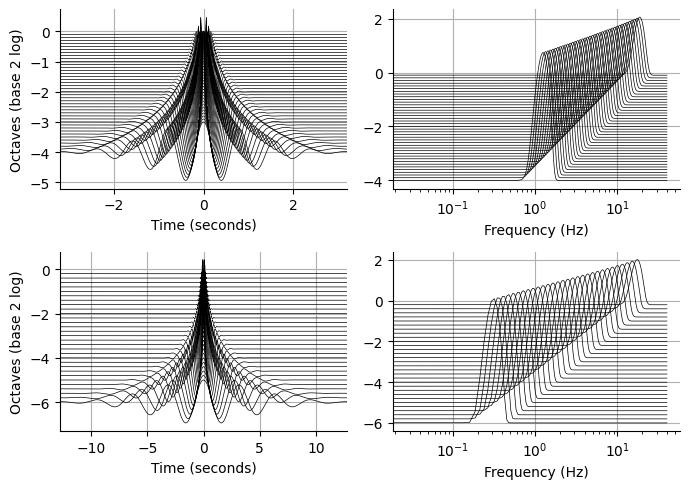

In [5]:

# Loop over network layers
#plt.figure(figsize=(10,5))

#cc = low_pass_filter(2000, sigma = 0.2)
fig, ax = plt.subplots(2, 2, figsize=(7,5),  )


for i, bank in enumerate(network.banks):

    # Create axes (left for temporal, right for spectral domain)
    
    ii = 0
    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
    ):

        # Time domain
        ax[i,0].plot(bank.times, wavelet.real + ratio, c= 'k', lw = 0.5)
        #ax[i,0].plot(bank.times, wavelet.imag + ratio, c='r', lw = 0.5)

        # Spectral domain (log of amplitude)
        ax[i,1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, c = 'k', lw = 0.5)
        #ax[i,2].plot(bank.frequencies, np.log(np.abs(spectrum*cc[1000:]) + 1) + ratio, c = 'b', lw = 0.5)
        
    #ax[0,1].plot(bank.frequencies, np.log(np.abs(cc[1000:]) + 1) -0.25, c = 'r', lw = 0.5)

    # Limit view to three times the temporal width of largest wavelet
    width_max = 2 * bank.widths.max()

    # Labels
    
    
    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()

    #ax[i, 0].set_xlim(0.1, 50)
    #  
    #ax[i,2].set_xscale("log")
    #ax[i,2].set_xlabel("Frequency (Hz)")
    #ax[i,2].grid()
    #ax[i, 1].set_xlim(0.1, 50)
    
    ii = ii+1

for axn in ax.flat:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)


    
fig.tight_layout()
fig.savefig(savepath + f'filterbank.pdf', transparent=True, dpi = 300)


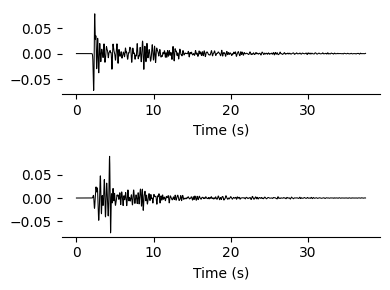

In [6]:

time = np.arange(0, data.shape[-1], 1) / sr
indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]


fig, axs = plt.subplots(2, 1, figsize = (4, 3))

axs[0].plot(time, data[indxvs[75, 30], 0, :].T,lw = 0.75, c = 'k')

axs[1].plot(time, data[indxvs[75, 30], 1, :].T,lw = 0.75, c = 'k')


ax = axs[0]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Time (s)')

ax = axs[1]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Time (s)')

fig.tight_layout()
fig.savefig(savepath + f'seismograms.pdf', transparent=True)



In [7]:


from scatseisnet import ScatteringNetwork

segment_duration_seconds = data.shape[-1]/sr

sampling_rate_hertz = sr

samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)



bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 10, "quality": 2, "taper_alpha" : 0.},
    {"octaves": 6 , "resolution": 5, "quality": 2, "taper_alpha" : 0.},
     )



network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )

print(network)



ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=10, quality=2, sampling_rate=40, len=40)
ComplexMorletBank(bins=1500, octaves=6, resolution=5, quality=2, sampling_rate=40, len=30)


In [8]:
segments = [data[i,:,:] for i in indxvs[indx, 30]]


sc1 = network.transform(segments,  reduce_type= None )



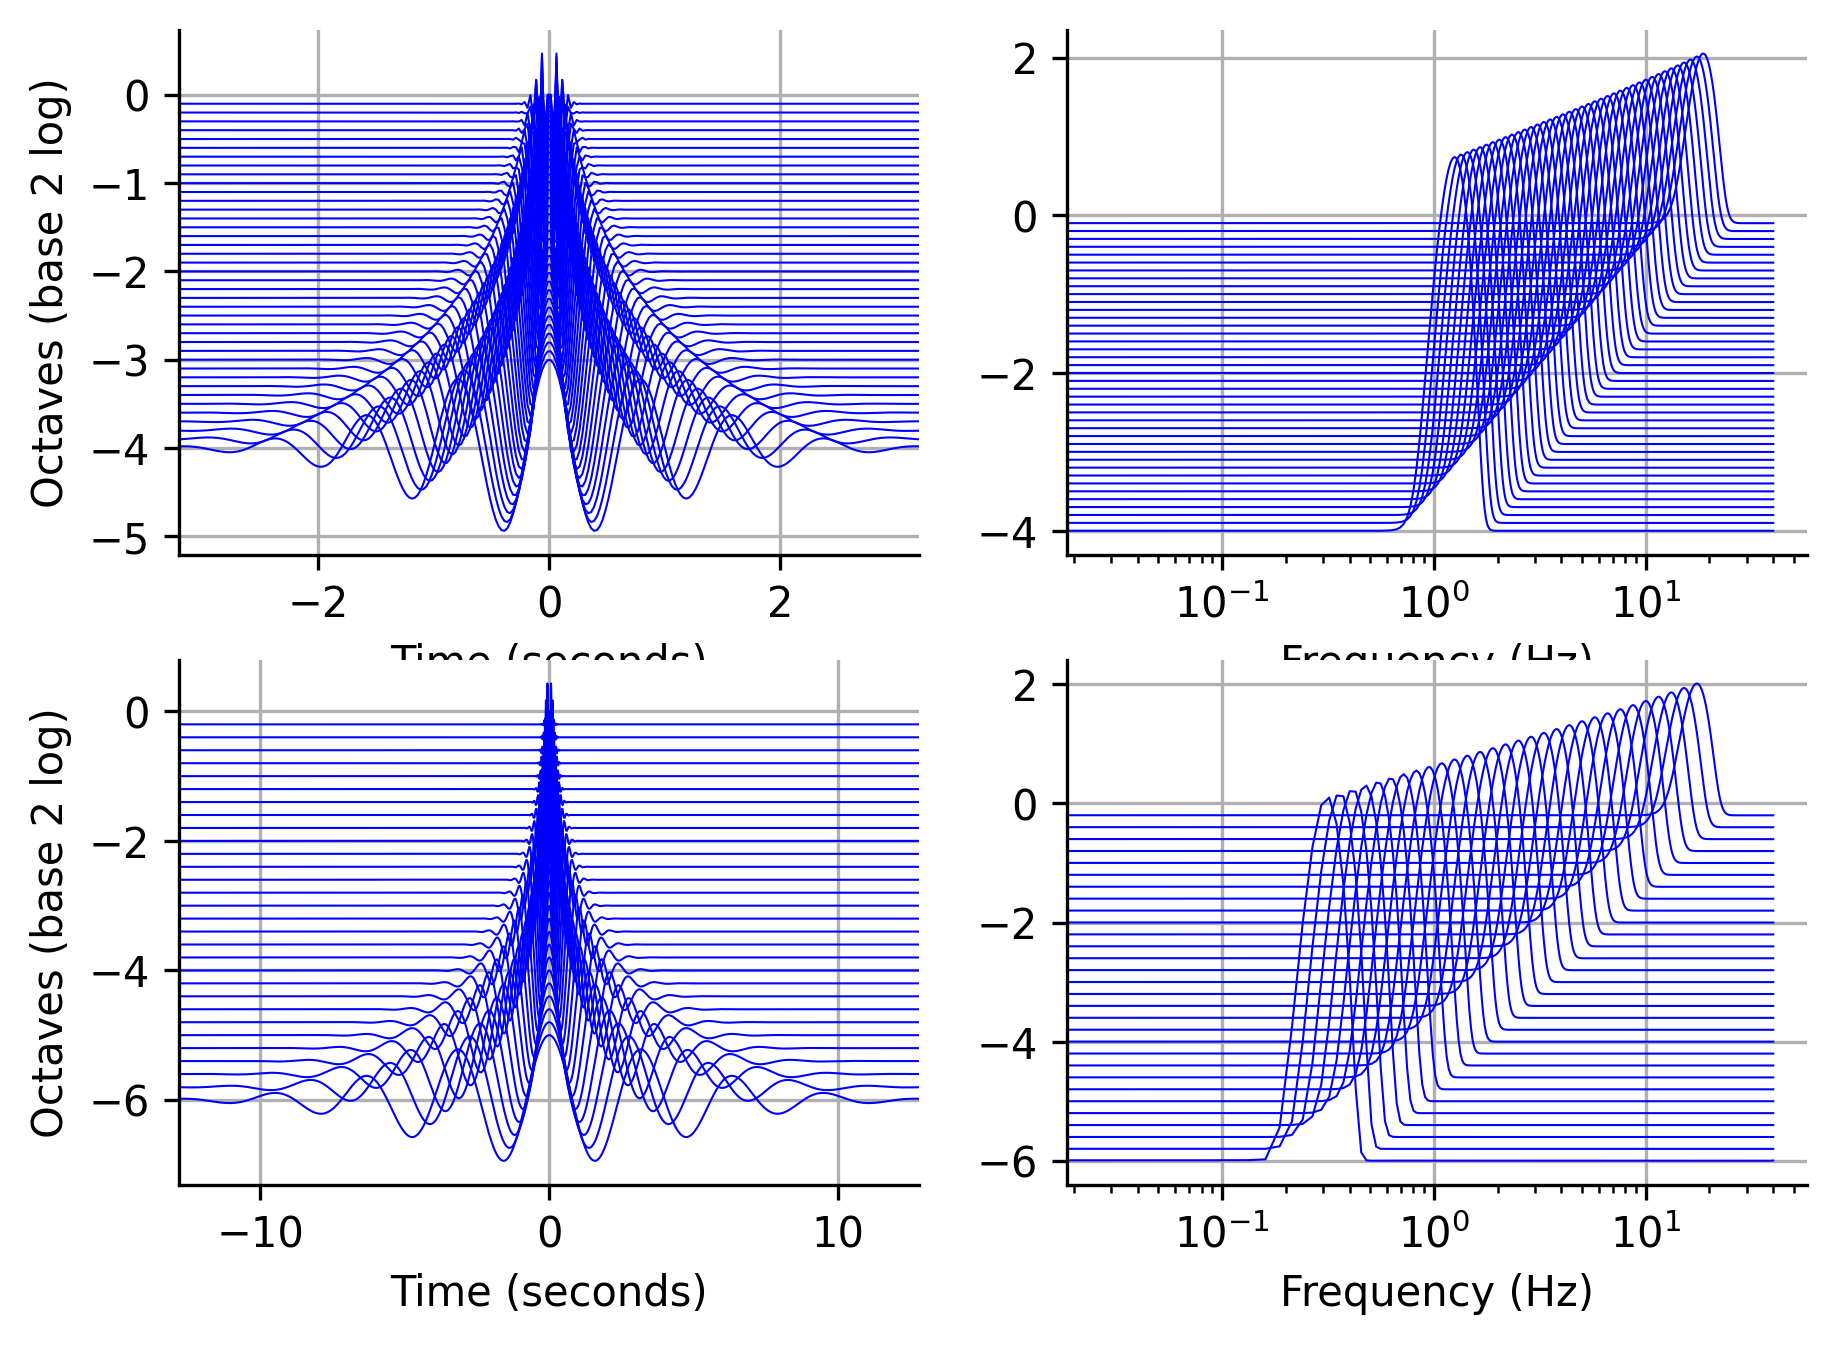

In [9]:

# Loop over network layers
#plt.figure(figsize=(10,5))

#cc = low_pass_filter(2000, sigma = 0.2)
fig, ax = plt.subplots(2, 2, figsize=(7,5),  dpi =300)


for i, bank in enumerate(network.banks):

    # Create axes (left for temporal, right for spectral domain)
    
    ii = 0
    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
    ):

        # Time domain
        ax[i,0].plot(bank.times, wavelet.real + ratio, c= 'b', lw = 0.5)
        #ax[i,0].plot(bank.times, wavelet.imag + ratio, c='r', lw = 0.5)

        # Spectral domain (log of amplitude)
        ax[i,1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, c = 'b', lw = 0.5)
        #ax[i,2].plot(bank.frequencies, np.log(np.abs(spectrum*cc[1000:]) + 1) + ratio, c = 'b', lw = 0.5)
        
    #ax[0,1].plot(bank.frequencies, np.log(np.abs(cc[1000:]) + 1) -0.25, c = 'r', lw = 0.5)

    # Limit view to three times the temporal width of largest wavelet
    width_max = 2 * bank.widths.max()

    # Labels
    
    
    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()

    #ax[i, 0].set_xlim(0.1, 50)
    #  
    #ax[i,2].set_xscale("log")
    #ax[i,2].set_xlabel("Frequency (Hz)")
    #ax[i,2].grid()
    #ax[i, 1].set_xlim(0.1, 50)
    
    ii = ii+1

for axn in ax.flat:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)


    

In [10]:
time = np.arange(0, data.shape[-1], 1) / sr
indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]



In [11]:


#scm1 = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_normalized_wavelet_unnormalized_coda.npz')

#scm1 = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_unnormalized_wavelet_unnormalized.npz')

scm1 = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_normalized_l2_wavelet_unnormalized_median.npz')

#scm = np.load('/bettik/dokhtdor/projects/mirko_volcano_simulations/coefficients/sc_max_normalized_l2_wavelet_unnormalized_median.npz')


sc = [scm1['order_1'], scm1['order_2']]

#sc = [scm2['order_1'], scm2['order_2']]
for i in range(len(network.banks[0].centers)):

    n = network.banks[0].centers[i] <= network.banks[1].centers  # Find the center of the wavelet in the second layer that is closest to the center of the wavelet in the first layer
    sc[1][:,:, i, n] = np.nan

nnint = np.random.randint(0, 10, 10)

from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.preprocessing import RobustScaler, MinMaxScaler



sc[1] = sc[1][:,:, ...]

sc[0] = sc[0][:,:, ...]


/tmp/ipykernel_1112799/1043278269.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


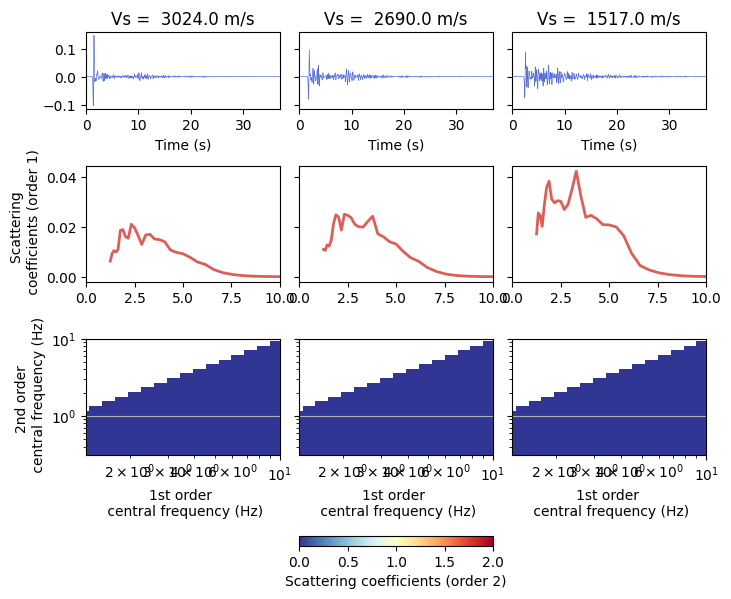

In [12]:


gs = {"hspace": 0.4, "wspace": 0.1, "height_ratios": [1,1.5, 3]}
fig, axs = plt.subplots(
        3, 3, figsize=(8, 7), sharex="row", sharey="row", gridspec_kw=gs
    )


offset_x = 30

trc = [35, 55, 80]

ax = axs[0].reshape(-1)

for i, ind in enumerate(trc):

    ax[i].set_title(f"Vs =  {np.ceil(vs.reshape(-1)[indxvs[ind, offset_x]])} m/s")
    ax[i].plot(np.arange(len(data[0,0,:]))/40, data[indxvs[ind, offset_x],0,:], lw = 0.5,  c = '#5770db')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_xlim(0, 37)

    
ax = axs[1].reshape(-1)


for i, ind in enumerate(trc):

    ax[i].plot(network.banks[0].centers, (sc[0][indxvs[ind, offset_x]][0]), lw = 2,  c = '#db5f57')

    #ax[i].plot(network.banks[0].centers, (sc2[0][indxvs[ind, offset_x]][0]), lw = 2,  c = 'k')

    #ax[i].set_xlabel('1st order \n frequency (Hz)')
    ax[i].set_xlim(0., 10)

ax[0].set_ylabel("Scattering \n coefficients (order 1)")
            
ax = axs[2].reshape(-1)

for i, ind in enumerate(trc):

    ss = (sc[1][indxvs[ind, offset_x]][0])
    #ss[np.isnan(ss)] = 0 
    
    img = ax[i].pcolormesh(network.banks[0].centers, network.banks[1].centers, np.log(ss[:,:].T)**1,  vmin = 0, vmax = 2 , cmap = 'RdYlBu_r', rasterized=True ) 
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[1].set_xlim(network.banks[0].centers.min(), 10)
    ax[1].set_ylim(network.banks[1].centers.min(), 10)

    ax[i].grid(True)

    ax[i].set_xlabel('1st order \n central frequency (Hz)')

    cb = plt.colorbar(img, ax=ax[i], orientation="horizontal", pad=0.35)
    cb.set_label("Scattering coefficients (order 2)")
    if i != 1:
        cb.ax.set_visible(False)


ax[0].set_ylabel('2nd order \n central frequency (Hz)')

fig.tight_layout()

plt.savefig(savepath + "Coefficients" + ".png", bbox_inches="tight", dpi=300, transparent=True,)



In [13]:

def normalizing(scattering_coefficients, sil = 5):
    
    ss = scattering_coefficients.copy()
    
    c1 = ss[0].copy()
    c2 = ss[1].copy()

    c2hat = c2/ (np.median(c1, -1)+ sil * np.nanmax(c1, -1) )[:,:,np.newaxis , np.newaxis] 


    c2hat[np.isnan(scattering_coefficients[1])] == np.nan
    
    return [c1, c2hat]
    



In [14]:
sc[1].shape

(7800, 10, 40, 30)

(7800, 10, 40)


(7800, 12400)

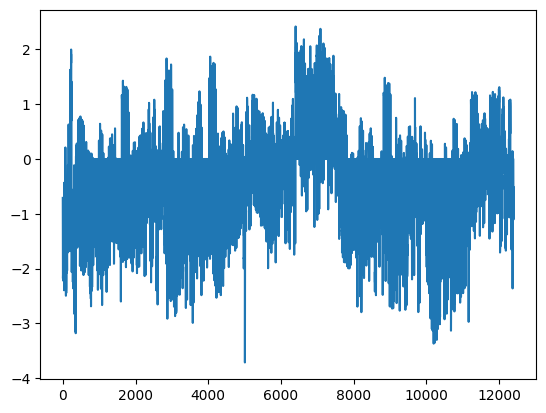

In [15]:

from sklearn.preprocessing import RobustScaler, MinMaxScaler

scc = normalizing(sc, sil = 1e-1)

#order_1 = np.median(sc[0][:, ::1 , :], axis = 1)
#order_1 = np.hstack([order_1, np.median(sc[0][:, 1::2 , :], axis = 1) ])

order_1 = sc[0]

print(order_1.shape)
order_1 = order_1.reshape(order_1.shape[0] , -1)


#order_2 = np.median(sc[1][:, ::1 , :, :], axis = 1)
#order_2 = np.hstack([order_2, np.median(sc[1][:, 1::2 , :, :], axis = 1) ])


order_2 = sc[1]


order_2 = order_2.reshape(order_2.shape[0], -1)
#order_2 = abs(order_2- np.nanmean(order_2, axis = 0))



cofficients =  np.hstack((order_1, order_2))
cofficients =  np.log((cofficients[:, :]) + 1e-10 )#* np.nanmax(cofficients) )


cofficients = np.nan_to_num(cofficients, 0)

pp = []
for i in range(cofficients.shape[0]):
    oi = cofficients[i, ~np.isnan(cofficients[i,:])]
    pp.append(oi)
#cofficients = np.asarray(pp)


transformer = MinMaxScaler(feature_range = (-1, 1)).fit(cofficients)
cofficients = transformer.transform(cofficients)

cofficients = RobustScaler().fit_transform(cofficients)

plt.plot(cofficients[0])


cofficients.shape

In [16]:

from sklearn.decomposition import FastICA, PCA, KernelPCA, SparsePCA, IncrementalPCA
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.cluster import KMeans

import umap

# explained_variance_score
from sklearn.metrics import explained_variance_score
from matplotlib import colors
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import explained_variance_score



In [17]:
    N_CLUSTERS = 3


    icamodel = PCA(n_components= N_CLUSTERS ,   )#fun = 'cube', max_iter= 5000, tol = 1e-20)

    features = icamodel.fit_transform(cofficients)


clustering = AgglomerativeClustering(n_clusters = 3,  linkage='ward').fit(features)

clusters  = clustering.labels_ 

In [18]:
iv  = icamodel.inverse_transform(features)

explained_variance_score(cofficients[:,:], iv[:,:])


0.5446844018924818

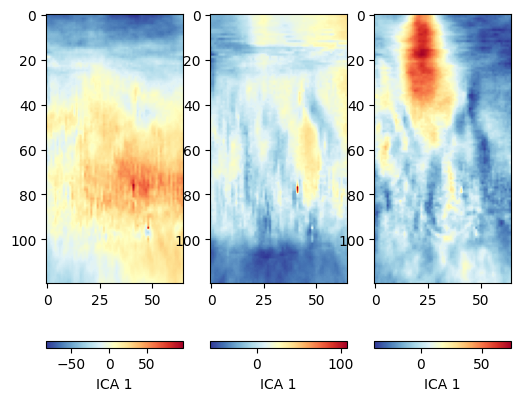

In [19]:
fig, axs = plt.subplots(1,N_CLUSTERS , figsize = (N_CLUSTERS*2, 5))

for i in range(N_CLUSTERS):
    ax = axs[i]
    im = ax.imshow(features[:, i].reshape(120, 65), aspect = 'auto', cmap = 'RdYlBu_r')
    plt.colorbar(im, ax = ax, orientation = 'horizontal', label = 'ICA 1')


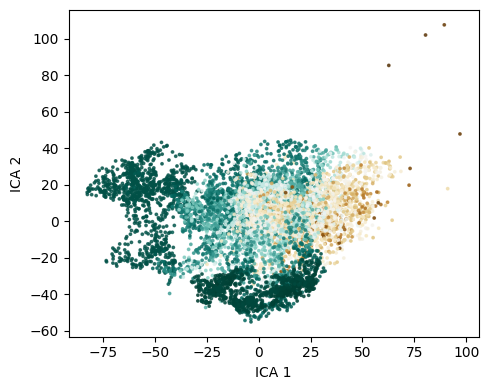

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

im = ax.scatter(features[:, 0], features[:, 1], c = vs.reshape(-1), cmap = 'BrBG', s = 3, alpha = 0.75, rasterized=True)

#plt.colorbar(im, ax = ax,  orientation = 'vertical', label = 'Shear wave \n velocty (m/s)')
ax.set_xlabel('ICA 1')
ax.set_ylabel('ICA 2')

plt.tight_layout()

plt.savefig(savepath + "PCA" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)


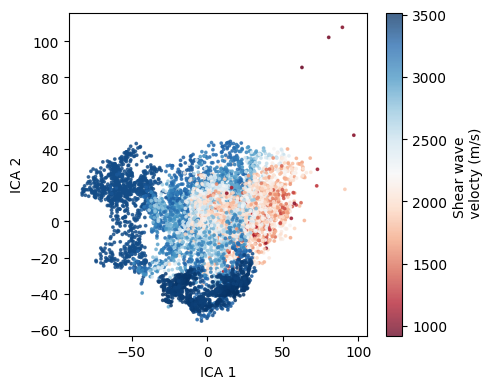

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

im = ax.scatter(features[:, 0], features[:, 1], c = vs.reshape(-1), cmap = 'RdBu', s = 3, alpha = 0.75, rasterized=True)

plt.colorbar(im, ax = ax,  orientation = 'vertical', label = 'Shear wave \n velocty (m/s)')
ax.set_xlabel('ICA 1')
ax.set_ylabel('ICA 2')

plt.tight_layout()

plt.savefig(savepath + "PCA2" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)


In [690]:

clustering = AgglomerativeClustering(n_clusters = 8,  linkage='ward').fit(features)

clusters  = clustering.labels_ 
clusters2 = clusters.copy()


In [691]:

import seaborn as sns

cmap2 = sns.color_palette("hls", 3)

print(cmap2.as_hex())




['#db5f57', '#57db5f', '#5f57db']


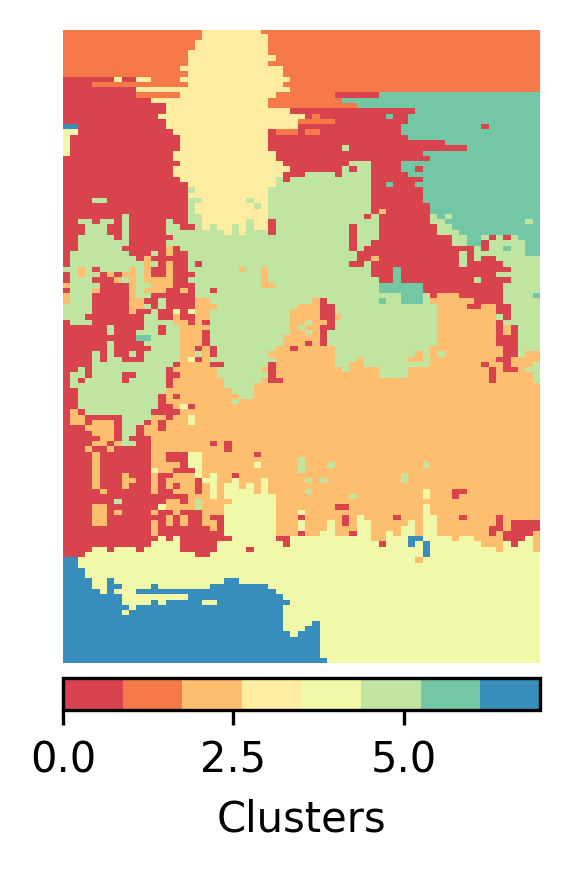

In [692]:

import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap


cmap = sns.diverging_palette(230, 30, as_cmap=True)
#cmap = sns.color_palette("mako", as_cmap=True)
#cmap = sns.color_palette("magma", as_cmap=True)
#cmap = sns.cubehelix_palette(as_cmap=True)
#cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
cmap = sns.color_palette("Spectral", as_cmap=True)

cmap2 = sns.color_palette("rocket")
cmap2 = sns.color_palette("ch:s=-.2,r=.6", )
#cmap2 = sns.color_palette("coolwarm")
cmap = 'RdYlBu'
cmap = plt.get_cmap('tab10', len(np.unique(clusters)))

cmap = ListedColormap(sns.color_palette("Spectral", len(np.unique(clusters))).as_hex())


fig, ax = plt.subplots( dpi = 300, figsize = (2, 3))

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)


# im1 = ax[0].imshow(-u2[:, 0].reshape(120, 65), cmap = cmap, aspect='auto', )
# im2 = ax[1].imshow(u2[:, 1].reshape(120, 65), cmap = cmap, aspect='auto', )

#feature = np.sqrt(features[:, 0]**2 + features[:, 1]**2)

im1 = ax.imshow(clusters2.reshape(120, 65), cmap = cmap, aspect='auto', rasterized=True)

# im1 = ax[0].imshow(features[:, 0].reshape(120, 65), cmap = cmap, aspect='auto', )
# im2 = ax[1].imshow(features[:, 1].reshape(120, 65), cmap = cmap, aspect='auto', )



cbar = fig.colorbar(im1, cax=cax1, orientation='horizontal', label = "Clusters", pad=0.35)

#fig.colorbar(im2, cax=cax2, orientation='horizontal', label = "low-dimensional space \n (2nd component)")

#yticks = np.linspace(0, len(np.unique(clusters))+4, 3 )[:-1] +0.5


#yticks[0] = 0.5
#yticks[1] = 3.5
#yticks[1] = 6.5

#yticks += (yticks[1] - yticks[0]) / 2


#cbar.set_ticks(yticks, labels=['LVZ',  'HVZ'])
ax.axis('off')


#ax[1].axis('off')

fig.tight_layout()
fig.savefig(savepath + f'cluster_best.pdf', transparent=True)



In [693]:

    fit2 = umap.UMAP(densmap=False,
        n_neighbors = 30, 
        min_dist = 0.,
        n_components = 2,
        random_state = 42,

        )

    u2 = fit2.fit_transform(
        
        #features[:,:],
        cofficients[:,:],
        #np.abs(c['sc']).reshape(7800,-1)
        )
        

/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


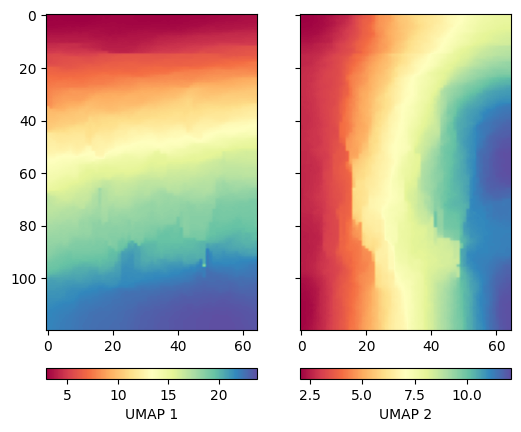

In [694]:
gs = {"hspace": 0.1, "wspace": 0.1, "width_ratios": [1, 1]}
cmap = sns.color_palette("Spectral", as_cmap=True)

fig, axs = plt.subplots(1, 2, figsize = (6, 5), sharey=True, )

ax = axs[0]
gain = 3
lnrwidth=10

pcm = ax.imshow((u2[:,0].reshape(120, 65)), cmap = cmap, aspect='auto', rasterized=True,)

fig.colorbar(pcm, ax=ax,  fraction=0.08, pad=0.1, orientation='horizontal', label = 'UMAP 1')
#ax.contour(X, Y, vs, cmap = 'flag', alpha = 0.75 , linewidths = 0.75 )

ax = axs[1]

pcm = ax.imshow((u2[:, 1].reshape(120, 65)), cmap = cmap, aspect='auto',
)

cbar = fig.colorbar(pcm, ax=ax,  fraction=0.08, pad=0.1, orientation='horizontal', label = 'UMAP 2')


plt.savefig(savepath + "umap__2d" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)


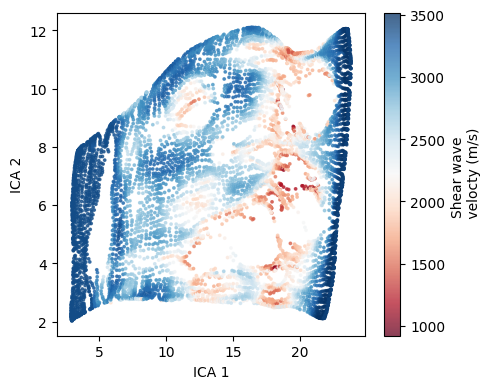

In [695]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

im = ax.scatter(u2[:, 0], u2[:, 1], c = vs.reshape(-1), cmap = 'RdBu', s = 3, alpha = 0.75, rasterized=True)
ax.title
plt.colorbar(im, ax = ax,  orientation = 'vertical', label = 'Shear wave \n velocty (m/s)')
ax.set_xlabel('ICA 1')
ax.set_ylabel('ICA 2')

plt.tight_layout()

plt.savefig(savepath + "umap_test" + ".pdf", bbox_inches="tight", dpi=300, transparent=True,)



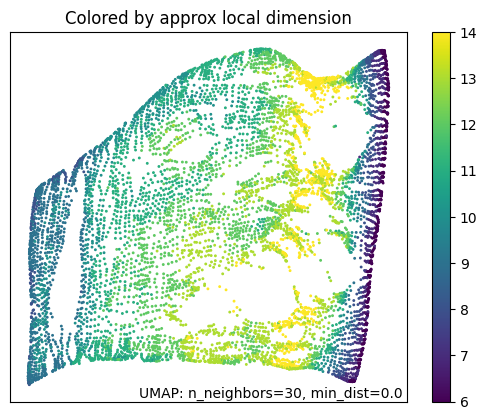

In [696]:

fig_localdim, axs_localdim = plt.subplots(1, )


local_dims = umap.plot.diagnostic(fit2, diagnostic_type='local_dim', ax = axs_localdim, local_variance_threshold=0.7)



fig.savefig(savepath+f'local_dim.png', bbox_inches="tight", dpi=300 , transparent=True)

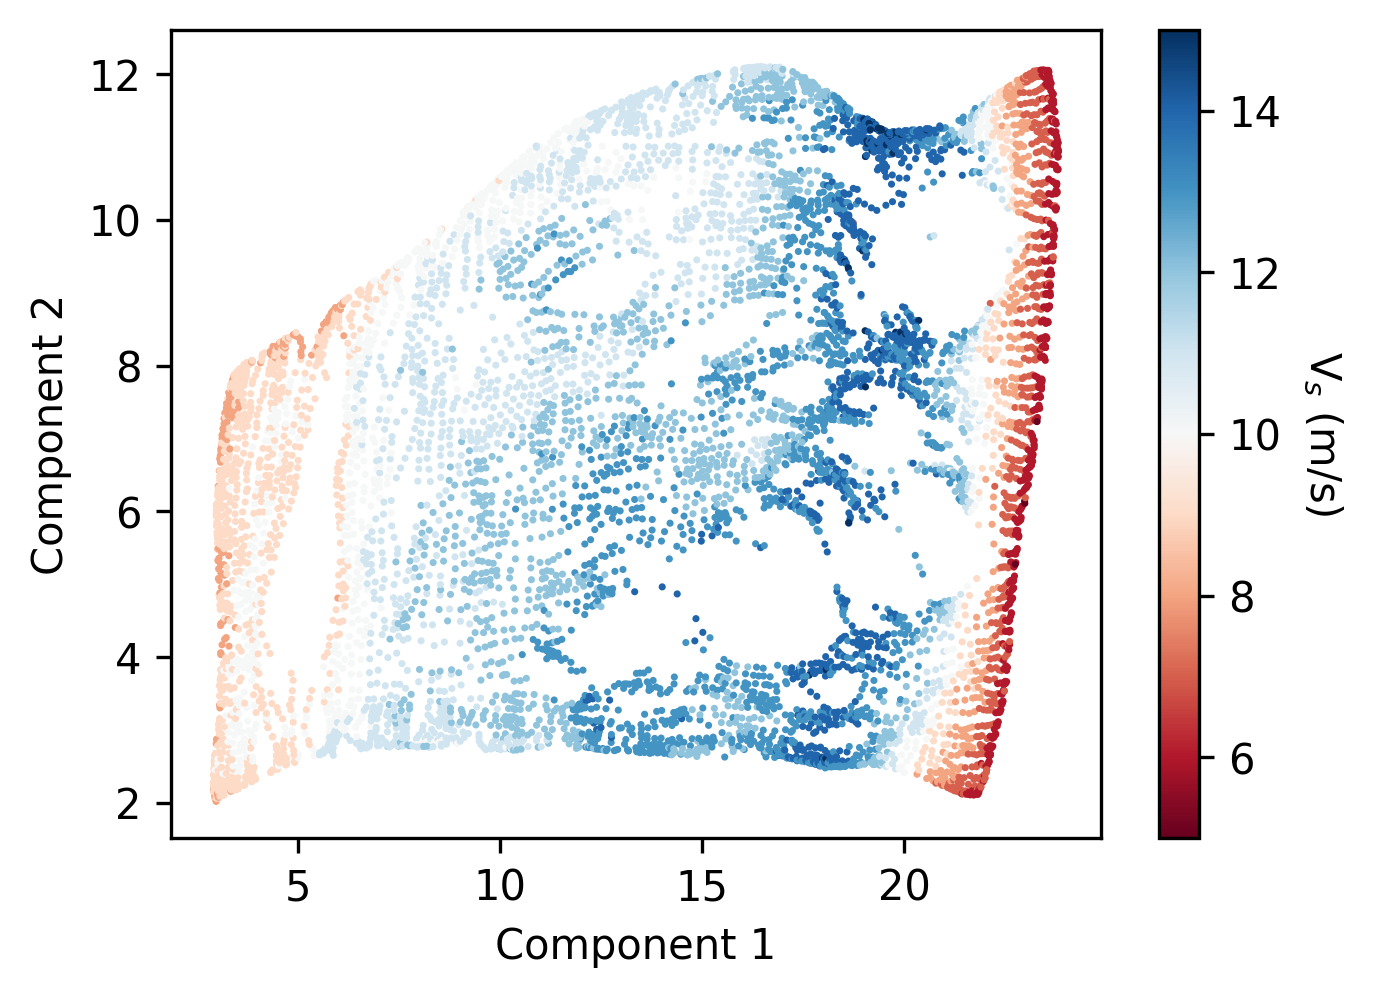

In [697]:
ax=fig_localdim.get_axes()[0]

x_r=ax.collections[0].get_offsets()[:,0]
y_r=ax.collections[0].get_offsets()[:,1]

z_r=ax.collections[0].get_array()

plt.figure(dpi =300, figsize = (5, 3.5))

plt.scatter(x_r, y_r, c = z_r, s = 0.5, cmap = 'RdBu')

cbar = plt.colorbar()
cbar.set_label('V$_{s}$ (m/s)', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

plt.xlabel('Component 1')
plt.ylabel('Component 2')

#plt.title(f'n_neighbors = {20}, min_dist = {min_dist}')

plt.savefig(savepath+f'local_dimensionality.png', bbox_inches="tight", dpi=300)



/tmp/ipykernel_127154/290356368.py:14: UserWarning: Adding colorbar to a different Figure <Figure size 1200x900 with 2 Axes> than <Figure size 500x400 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(pcm, ax=axs,  fraction=0.08, pad=0.04)


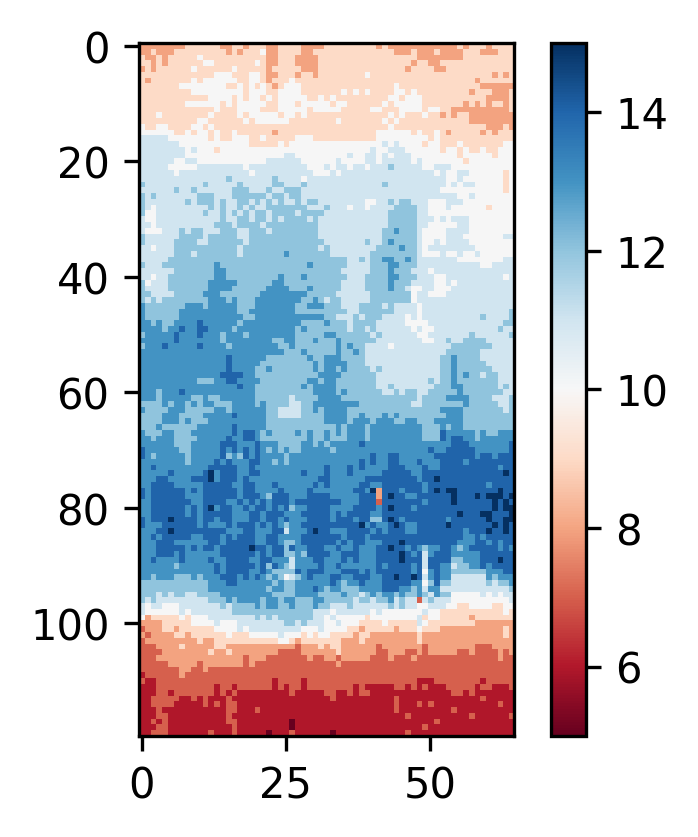

In [698]:


ax=fig_localdim.get_axes()[0]

x_r=ax.collections[0].get_offsets()[:,0]
y_r=ax.collections[0].get_offsets()[:,1]

z_r=ax.collections[0].get_array()

fig2, axs = plt.subplots(1,1, figsize= (4, 3), dpi =300)

pcm = axs.imshow(z_r.data.reshape(120, 65) , cmap = 'RdBu')

#plt.contour(X, Y, vs, cmap = 'flag', alpha = 0.75 , linewidths = 0.75 )

fig.colorbar(pcm, ax=axs,  fraction=0.08, pad=0.04)

fig2.savefig(savepath+f'local_dim_model.png', bbox_inches="tight", dpi=300 , transparent=True)




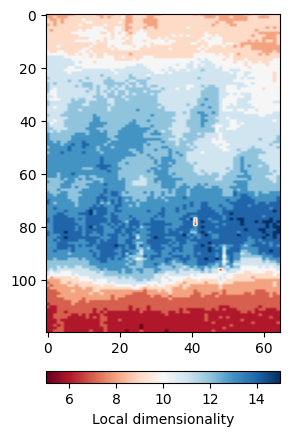

In [699]:

gs = {"hspace": 0.1, "wspace": 0.1, "width_ratios": [1, 1]}
cmap = sns.color_palette("Spectral", as_cmap=True)

fig, axs = plt.subplots(1, 1, figsize = (3, 4.5), sharey=True, )

ax = axs

gain = 3
lnrwidth=10

pcm = ax.imshow( z_r.data.reshape(120, 65) , cmap = 'RdBu', aspect='auto', rasterized=True,)

fig.colorbar(pcm, ax=ax,  fraction=0.08, pad=0.1, orientation='horizontal', label = 'Local dimensionality')
#ax.contour(X, Y, vs, cmap = 'flag', alpha = 0.75 , linewidths = 0.75 )

fig.tight_layout()
fig.savefig(savepath+f'local_dim_model.pdf', bbox_inches="tight", dpi=300 , transparent=True)
